In [3]:
import numpy

## Гомографии
Гомография - проективное преобразование одной плоскости в другую. Гомография отображает точки плоскости в однородных координатах. Однородные координаты - полезное представление точек в плоскости изображения (и в трехмерном пространстве). В однородных координатах точка определена лишь с точностью до масштабного коэффициента.

In [4]:
def normalize (points):
    #Нормировать коллекцию точек в однородных координатах, так чтобы последняя строка была равна 1. 
    for row in points:
        row /= points[-1]
    return points

def make_homog (points) : 
    #преобразовать множество точек (массив dim*n) в однородные координаты."""
    return numpy.vstack (points, numpy.ones ((1,points.shape[1])))


## Алгоритм прямолинейного преобразования
Гомографию можно вычислить непосредственно, зная соответственные точки двух изображений (или плоскостей). Прямое линейное преобразование - это алгоритм вычисления H по четырем и более парам соответственных точек.

In [12]:
import numpy as np
from numpy.linalg import svd, inv

def Haffine_from_points (fp, tp) :
  #Найти гомографию Н, отображающую fp в tp.
  if fp.shape != tp.shape:
    raise RuntimeError("расхождение в количестве точек")
  # обеспечить хорошую обусловленность точек
  # --точки первого изображения--
  m = np.mean(fp[:2], axis=1)
  maxstd = max(np.std(fp[:2], axis=1)) + 1e-9
  C1 = np.diag([1/maxstd, 1/maxstd, 1])
  C1[0][2] = -m[0] /maxstd
  C1[1][2] = -m[1] /maxstd
  fp_cond = np.dot (C1, fp)
  # --точки второго изображения—
  m = np.mean(tp[:2], axis=1)
  C2 = C1.copy()# в обоих наборах точек масштаб должен быть одинаков
  C2[0][2] = -m[0] /maxstd
  C2[1][2] = -m[1]/maxstd
  tp_cond = np.dot (C2, tp)
  # после обусловливания среднее точек равно 0, поэтому вектор
  # параллельного переноса нулевой
  A = np.concatenate((fp_cond[:2],tp_cond[:2]), axis = 0)
  U,S,V = svd(A.T)
  # Создать матрицы В и С, как описано у Хартли и Циммермана
  # (второе издание), на стр. 130.
  tmp = V[:2].T
  B= tmp[:2]
  C = tmp[2:4]
  tmp2 = np.concatenate ( (np.dot (C, np.linalg.pinv(B)), np.zeros ((2,1))), axis=1)
  H = np.vstack((tmp2, (0,0,1)))
  # обращение обусловливания
  H = np.dot(inv (C2), np.dot (H,C1))
  return H / H[2,2]



## Аффинные преобразования
Аффинное преобразование - отображение плоскости или пространства в себя, при котором параллельные прямые переходят в параллельные прямые, пересекающиеся - в пересекающиеся, скрещивающиеся - в скрещивающиеся. Данная функция вычисляет матрицу аффинного преобразования по парам соответственных точек.

In [13]:
import numpy

def Haffine_from_points(fp, tp):
    # Найти гомографию H, отображающую fp в tp.
    if fp.shape != tp.shape:
        raise RuntimeError("расхождение в количестве точек")
        
    # Обеспечить хорошую обусловленность точек
    # --точки первого изображения--
    m = numpy.mean(fp[:2], axis=1)
    maxstd = numpy.max(numpy.std(fp[:2], axis=1)) + 1e-9
    C1 = numpy.diag([1/maxstd, 1/maxstd, 1])
    C1[0][2] = -m[0] / maxstd
    C1[1][2] = -m[1] / maxstd
    fp_cond = numpy.dot(C1, fp)
    
    # --точки второго изображения—
    m = numpy.mean(tp[:2], axis=1)
    C2 = C1.copy()  # в обоих наборах точек масштаб должен быть одинаков
    C2[0][2] = -m[0] / maxstd
    C2[1][2] = -m[1] / maxstd
    tp_cond = numpy.dot(C1, tp)
    
    # После обусловливания среднее точек равно 0, поэтому вектор
    # параллельного переноса нулевой
    A = numpy.concatenate((fp_cond[:2], tp_cond[:2]), axis=0)
    U, S, V = numpy.linalg.svd(A.T)
    
    # Создать матрицы B и c, как описано у Хартли и Циммермана
    # (второе издание), на стр. 130.
    tmp = V[:2].T
    B = tmp[:2]
    c = tmp[2:4]

    tmp1 = numpy.dot(c, numpy.linalg.pinv(B))
    zeros = numpy.zeros((2, 1))
    tmp2 = numpy.concatenate((tmp1, zeros), axis=1)
    H = numpy.vstack((tmp2, [0, 0, 1]))
    
    # Обращение обусловливания
    H = numpy.dot(numpy.linalg.inv(C2), numpy.dot(H, C1))
    
    return H / H[2, 2]


## Деформирование изображений
Деформация изображения с помощью аффинного преобразования.

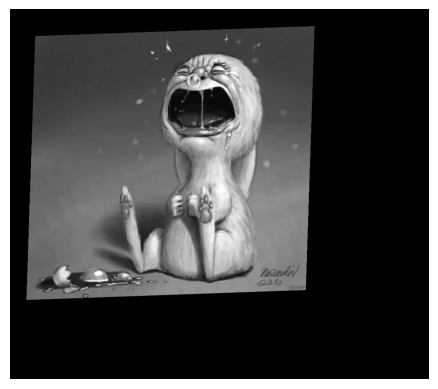

In [14]:
from scipy import ndimage
from matplotlib import pyplot as plt 
from PIL import Image #загрузка из Pillow класса Image
import numpy as np

im =  np.array(Image.open("img5.jpg").convert ("L"))
H = np.array([[1.4,0.05,-100], [0.05,1.5,-100], [0,0,1]])
im2 = ndimage.affine_transform(im, H[:2,:2], (H[0,2],H[1,2]))
plt.figure()
plt.gray()
plt.imshow(im2)
plt.axis('off') 
plt.show()


## Изображение внутри изображения
Функция принимает два изображения и координаты углов области внутри второго изображения, куда следует поместить первое изображение. Смешивая два изображения, мы создаем альфа-отображение, которое определяет, какую часть цвета пикселя брать из каждого изображения.

In [15]:

def image_in_image(im1, im2, tp):
    """ Поместить im1 в im2 с помощью аффинного преобразования, так чтобы углы были как можно ближе к tp. Углы tp выражены в однородных координатах и перечисляются против часовой стрелки, начиная с левого верхнего. """
    # точки деформируемого изображения
    m,n = im1.shape[:2]
    fp = np.array([[0,m,m,0],[0,0,n,n],[1,1,1,1]])
    # вычислить и применить аффинное преобразование
    H = Haffine_from_points(tp, fp)
    # H = compute_affine_matrix(tp,fp)
    im1_t=ndimage.affine_transform(im1,H[:2,:2], 
                                  (H[0,2],H[1,2]),im2.shape[:2])
    alpha = (im1_t > 0)
    return (1-alpha)*im2 + alpha*im1_t


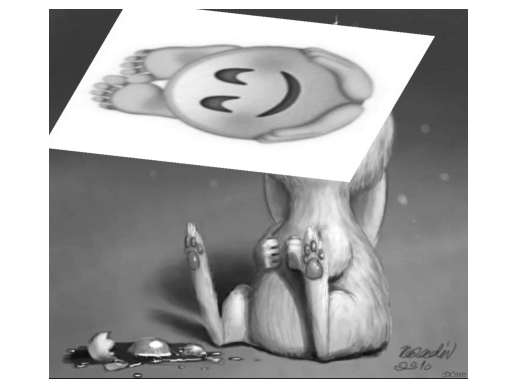

In [16]:

# пример аффинного деформирования im1 в im2
im1 = np.array(Image.open("img6.jpg").convert ("L"))
im2 = np.array(Image.open("img5.jpg").convert ("L"))
# задать точки
tp = np.array([[550, 50,200,50], [200, 50,1500,200], [0,0,1,1]])
im3 = image_in_image(im1, im2, tp)
plt.figure()
plt.gray()
plt.imshow(im3)
plt.axis('equal')
plt.axis('off')
plt.show()


In [17]:
def alpha_for_triangle(points,m,n): 
    """ Создает альфа-отображение размера (пл) для треугольника, определенного своими вершинами (заданными нормированными однородными координатами). """

    alpha = np.zeros((m,n))
    for i in range (min(points[0]),max (points [0])):
        for j in range(min(points[1]) ,max (points [1])):
            x= np.linalg.solve (points, [i,j,1])
            if min(x) > 0: #все коэффициенты положительные
                alpha[i,j] = 1
    return alpha


## Упражнение

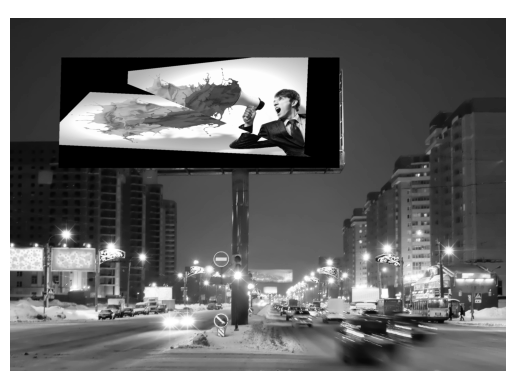

In [18]:
im1 = np.array(Image.open("img1.jpg").convert ("L"))
im2 = np.array(Image.open("img2.jpg").convert ("L"))
# сопоставим исходные точки углам im1
m,n = im1.shape[:2]
fp = np.array([[0,m,m,0],[0,0,n,n],[1,1,1,1]])
tp = np.array([ [200, 760, 760,200],
               [260, 245, 1670,1670],
               [1, 1, 1, 1]])             # веса (в данном случае все равны 1)
# первый треугольник
tp2=tp[:,:3]
fp2=fp[:,:3]
# вычислить H
H = Haffine_from_points(tp2, fp2)
im1_t = ndimage.affine_transform(im1,H[:2,:2],
                                 (H[0,2],H[1,2]),im2.shape[:2])
# альфа – отображение для треугольника
alpha = alpha_for_triangle(tp2, im2.shape[0], im2.shape[1])
im3 = (1-alpha)*im2 + alpha*im1_t
# второй треугольник
tp2 = tp[:,[0,2,3]]
fp2 = fp[:,[0,2,3]]
# вычислить H
H = Haffine_from_points(tp2, fp2)
im1_t = ndimage.affine_transform(im1, H[:2,:2],
                                 (H[0,2],H[1,2]),im2.shape[:2])
# альфа – отображение для треугольника
alpha = alpha_for_triangle(tp2, im2.shape[0],im2.shape[1])
im4 = (1-alpha)*im3 + alpha*im1_t
plt.figure()
plt.gray()
plt.imshow(im4)
plt.axis('equal')
plt.axis('off')
plt.show()
